
Correlation Analysis:
Chicago: r = 0.463, p = 0.000, n = 73
Los Angeles: r = 0.178, p = 0.141, n = 70
New York: r = 0.425, p = 0.009, n = 37


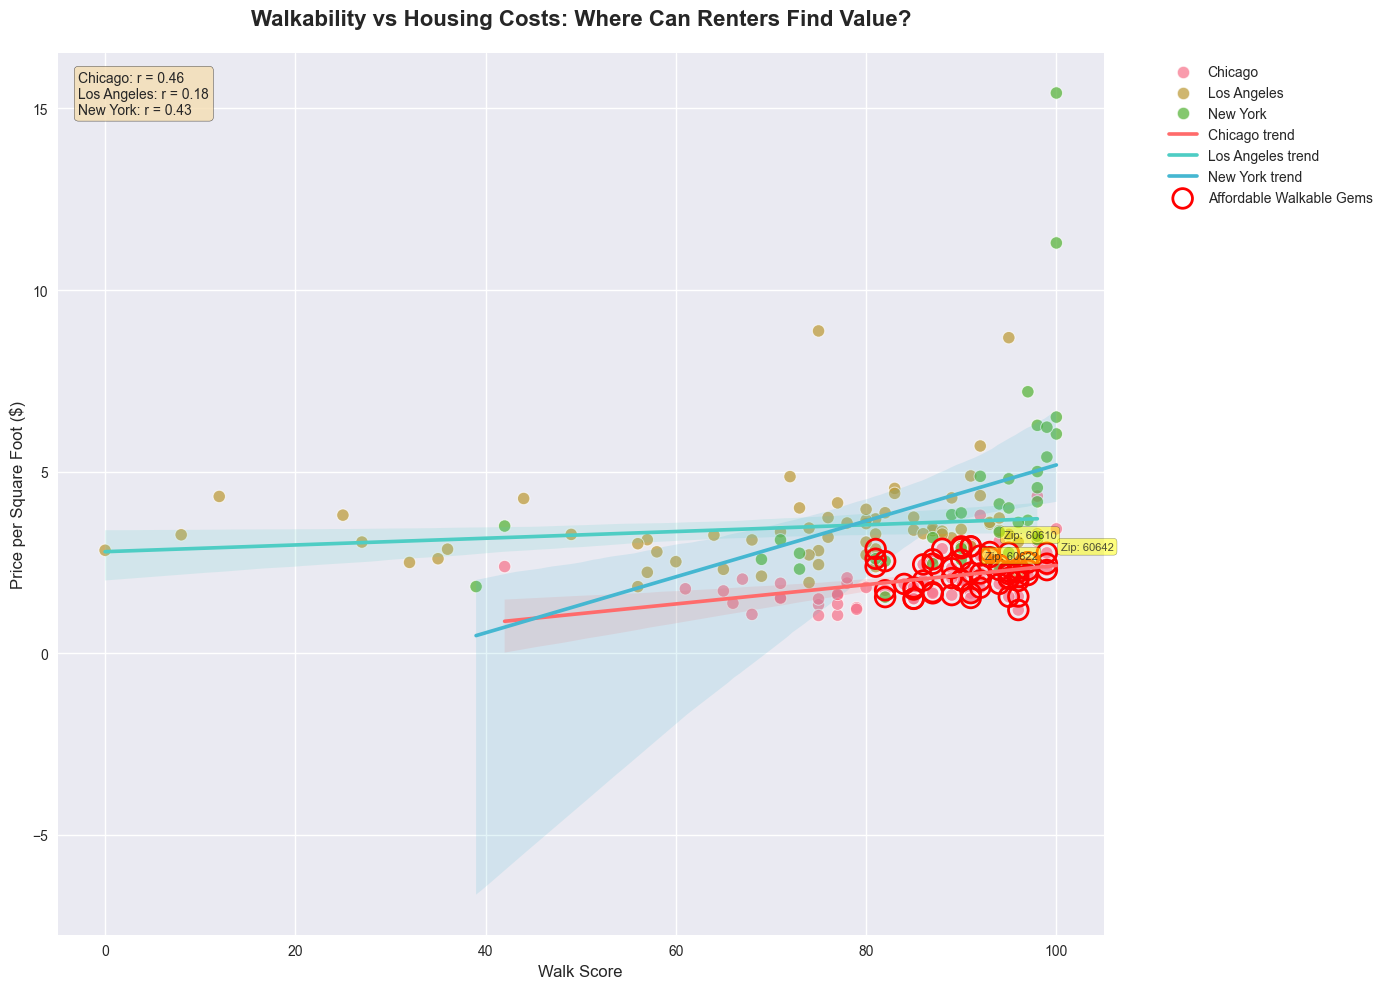


KEY INSIGHTS AND SUMMARY STATISTICS

Chicago:
Correlation: 0.463
20-point Walk Score increase leads to a 25.9% price increase
Average price/sqft: $2.05
Price range: $1.04 - $4.32

Los Angeles:
Correlation: 0.178
20-point Walk Score increase leads to a 5.3% price increase
Average price/sqft: $3.47
Price range: $1.83 - $8.87

New York:
Correlation: 0.425
20-point Walk Score increase leads to a 35.8% price increase
Average price/sqft: $4.31
Price range: $1.54 - $15.43

AFFORDABLE WALKABLE GEMS (Walk Score >80, Price <$3/sqft)
  Chicago, Zip 60608: Walk Score 96.0, $1.19/sqft
  Chicago, Zip 60623: Walk Score 85.0, $1.50/sqft
  Chicago, Zip 60612: Walk Score 85.0, $1.50/sqft
  Chicago, Zip 60626: Walk Score 91.0, $1.52/sqft
  New York, Zip 10314: Walk Score 82.0, $1.54/sqft


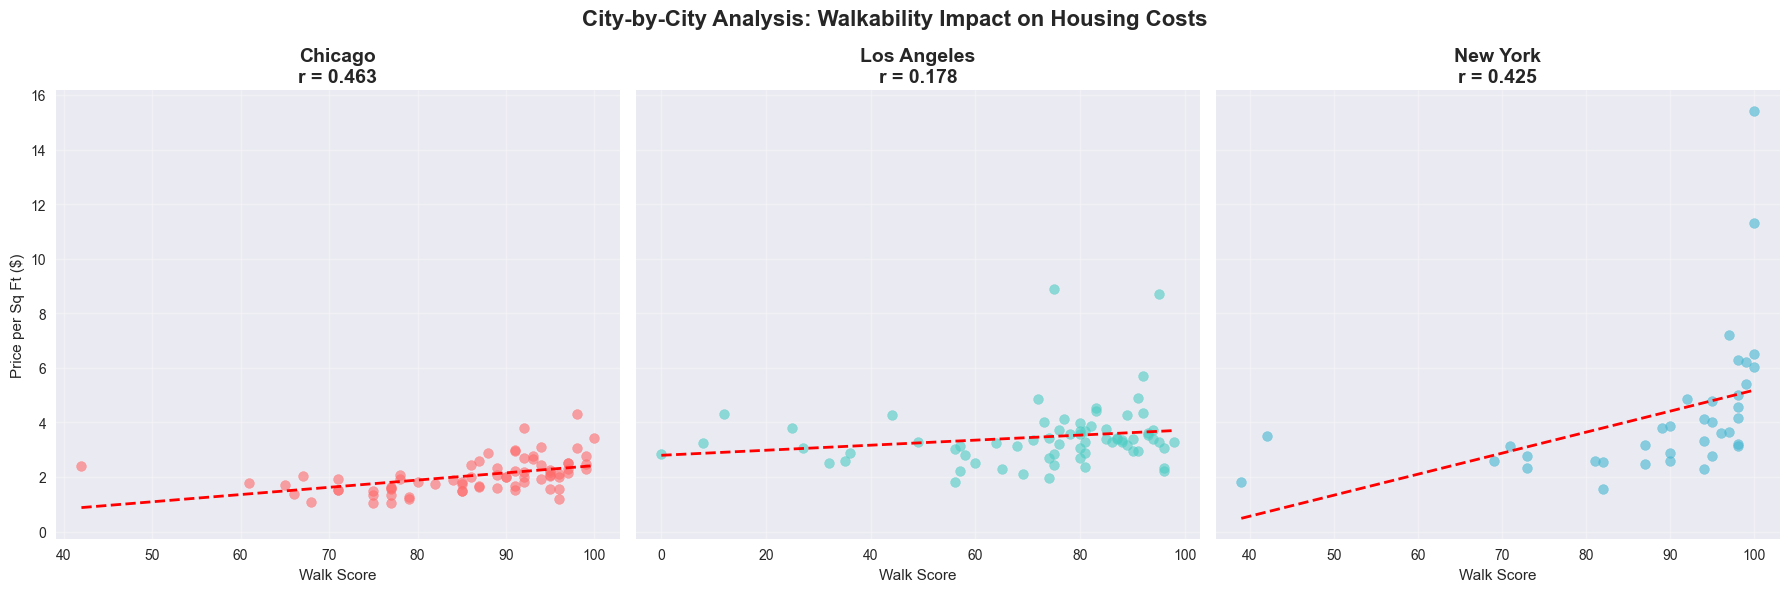

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#styles
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

#load the data
df = pd.read_csv('data/clean_data.csv')

#filter complete rows (non-null walkscore and price_per_sqft)
df_clean = df.dropna(subset=['walkscore', 'price_per_sqft']).copy()

#create city groups
df_clean['city_group'] = df_clean['state'].apply(lambda x: 
    'Chicago' if 'IL' in str(x) else
    'Los Angeles' if 'CA' in str(x) or 'LA' in str(x) else
    'New York' if 'NY' in str(x) or 'NYC' in str(x) else
    'Other'
)

#calculate correlations by city
correlations = {}
for city in ['Chicago', 'Los Angeles', 'New York']:
    city_data = df_clean[df_clean['city_group'] == city]
    if len(city_data) > 1:
        corr, p_value = pearsonr(city_data['walkscore'], city_data['price_per_sqft']) #pearson correlation
        correlations[city] = {'correlation': corr, 'p_value': p_value, 'n': len(city_data)}

print("\nCorrelation Analysis:")
for city, stats in correlations.items():
    print(f"{city}: r = {stats['correlation']:.3f}, p = {stats['p_value']:.3f}, n = {stats['n']}")

# MAIN SCATTER PLOT WITH SEABORN
plt.figure(figsize=(14, 10))

#create the scatter plot
ax = sns.scatterplot(
    data=df_clean[df_clean['city_group'].isin(['Chicago', 'Los Angeles', 'New York'])], 
    x='walkscore', 
    y='price_per_sqft', 
    hue='city_group',
    s=80,
    alpha=0.7
)

#add regression lines for each city
cities_to_plot = ['Chicago', 'Los Angeles', 'New York']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, city in enumerate(cities_to_plot):
    city_data = df_clean[df_clean['city_group'] == city]
    if len(city_data) > 1:
        sns.regplot(
            data=city_data, 
            x='walkscore', 
            y='price_per_sqft',
            scatter=False,
            color=colors[i],
            label=f'{city} trend',
            ax=ax
        ) #plot

#customize the plot
plt.title('Walkability vs Housing Costs: Where Can Renters Find Value?', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Walk Score', fontsize=12)
plt.ylabel('Price per Square Foot ($)', fontsize=12)

#add correlation text
textstr = '\n'.join([f'{city}: r = {stats["correlation"]:.2f}' 
                    for city, stats in correlations.items()])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

#highlight value opportunities (high walkscore, low price)
#"affordable walkable gems" - high walk score (>80), low price (<$3)
value_spots = df_clean[
    (df_clean['walkscore'] > 80) & 
    (df_clean['price_per_sqft'] < 3.0) &
    (df_clean['city_group'].isin(['Chicago', 'Los Angeles', 'New York']))
]

if len(value_spots) > 0:
    plt.scatter(value_spots['walkscore'], value_spots['price_per_sqft'], 
               s=200, facecolors='none', edgecolors='red', linewidth=2,
               label='Affordable Walkable Gems')
    
    #annotate a few examples cause u cant really see them
    for idx, row in value_spots.head(3).iterrows():
        plt.annotate(f'Zip: {row["zip_code"]}', 
                    (row['walkscore'], row['price_per_sqft']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=8, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# SUMMARY STATISTICS AND INSIGHTS
print("\n" + "="*60)
print("KEY INSIGHTS AND SUMMARY STATISTICS")
print("="*60)

#calculate percentage increase in price per walkscore point
for city in ['Chicago', 'Los Angeles', 'New York']:
    city_data = df_clean[df_clean['city_group'] == city]
    if len(city_data) > 1:
        #simple regression to get slope
        slope = np.polyfit(city_data['walkscore'], city_data['price_per_sqft'], 1)[0]
        mean_price = city_data['price_per_sqft'].mean()
        
        pct_increase = (slope * 20 / mean_price) * 100  #20-point walkscore increase
        
        print(f"\n{city}:")
        print(f"Correlation: {correlations[city]['correlation']:.3f}")
        print(f"20-point Walk Score increase leads to a {pct_increase:.1f}% price increase")
        print(f"Average price/sqft: ${mean_price:.2f}")
        print(f"Price range: ${city_data['price_per_sqft'].min():.2f} - ${city_data['price_per_sqft'].max():.2f}")

#find value opportunities
print(f"\n{'AFFORDABLE WALKABLE GEMS (Walk Score >80, Price <$3/sqft)':}")
value_gems = df_clean[
    (df_clean['walkscore'] > 80) & 
    (df_clean['price_per_sqft'] < 3.0)
].sort_values('price_per_sqft')

if len(value_gems) > 0:
    for idx, row in value_gems.head(5).iterrows():
        print(f"  {row['city_group']}, Zip {row['zip_code']}: Walk Score {row['walkscore']}, ${row['price_per_sqft']:.2f}/sqft")
else:
    print("   No properties found with Walk Score >80 and Price <$3/sqft")

# CITY COMPARISON SUBPLOT
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, city in enumerate(['Chicago', 'Los Angeles', 'New York']):
    city_data = df_clean[df_clean['city_group'] == city]
    
    if len(city_data) > 1:
        axes[i].scatter(city_data['walkscore'], city_data['price_per_sqft'], 
                       alpha=0.6, s=50, color=colors[i])
        
        #add regression line
        z = np.polyfit(city_data['walkscore'], city_data['price_per_sqft'], 1)
        p = np.poly1d(z)
        axes[i].plot(city_data['walkscore'].sort_values(), 
                    p(city_data['walkscore'].sort_values()), 
                    color='red', linestyle='--', linewidth=2)
        
        axes[i].set_title(f'{city}\nr = {correlations[city]["correlation"]:.3f}', 
                         fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Walk Score')
        if i == 0:
            axes[i].set_ylabel('Price per Sq Ft ($)')
        
        axes[i].grid(True, alpha=0.3)

plt.suptitle('City-by-City Analysis: Walkability Impact on Housing Costs', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


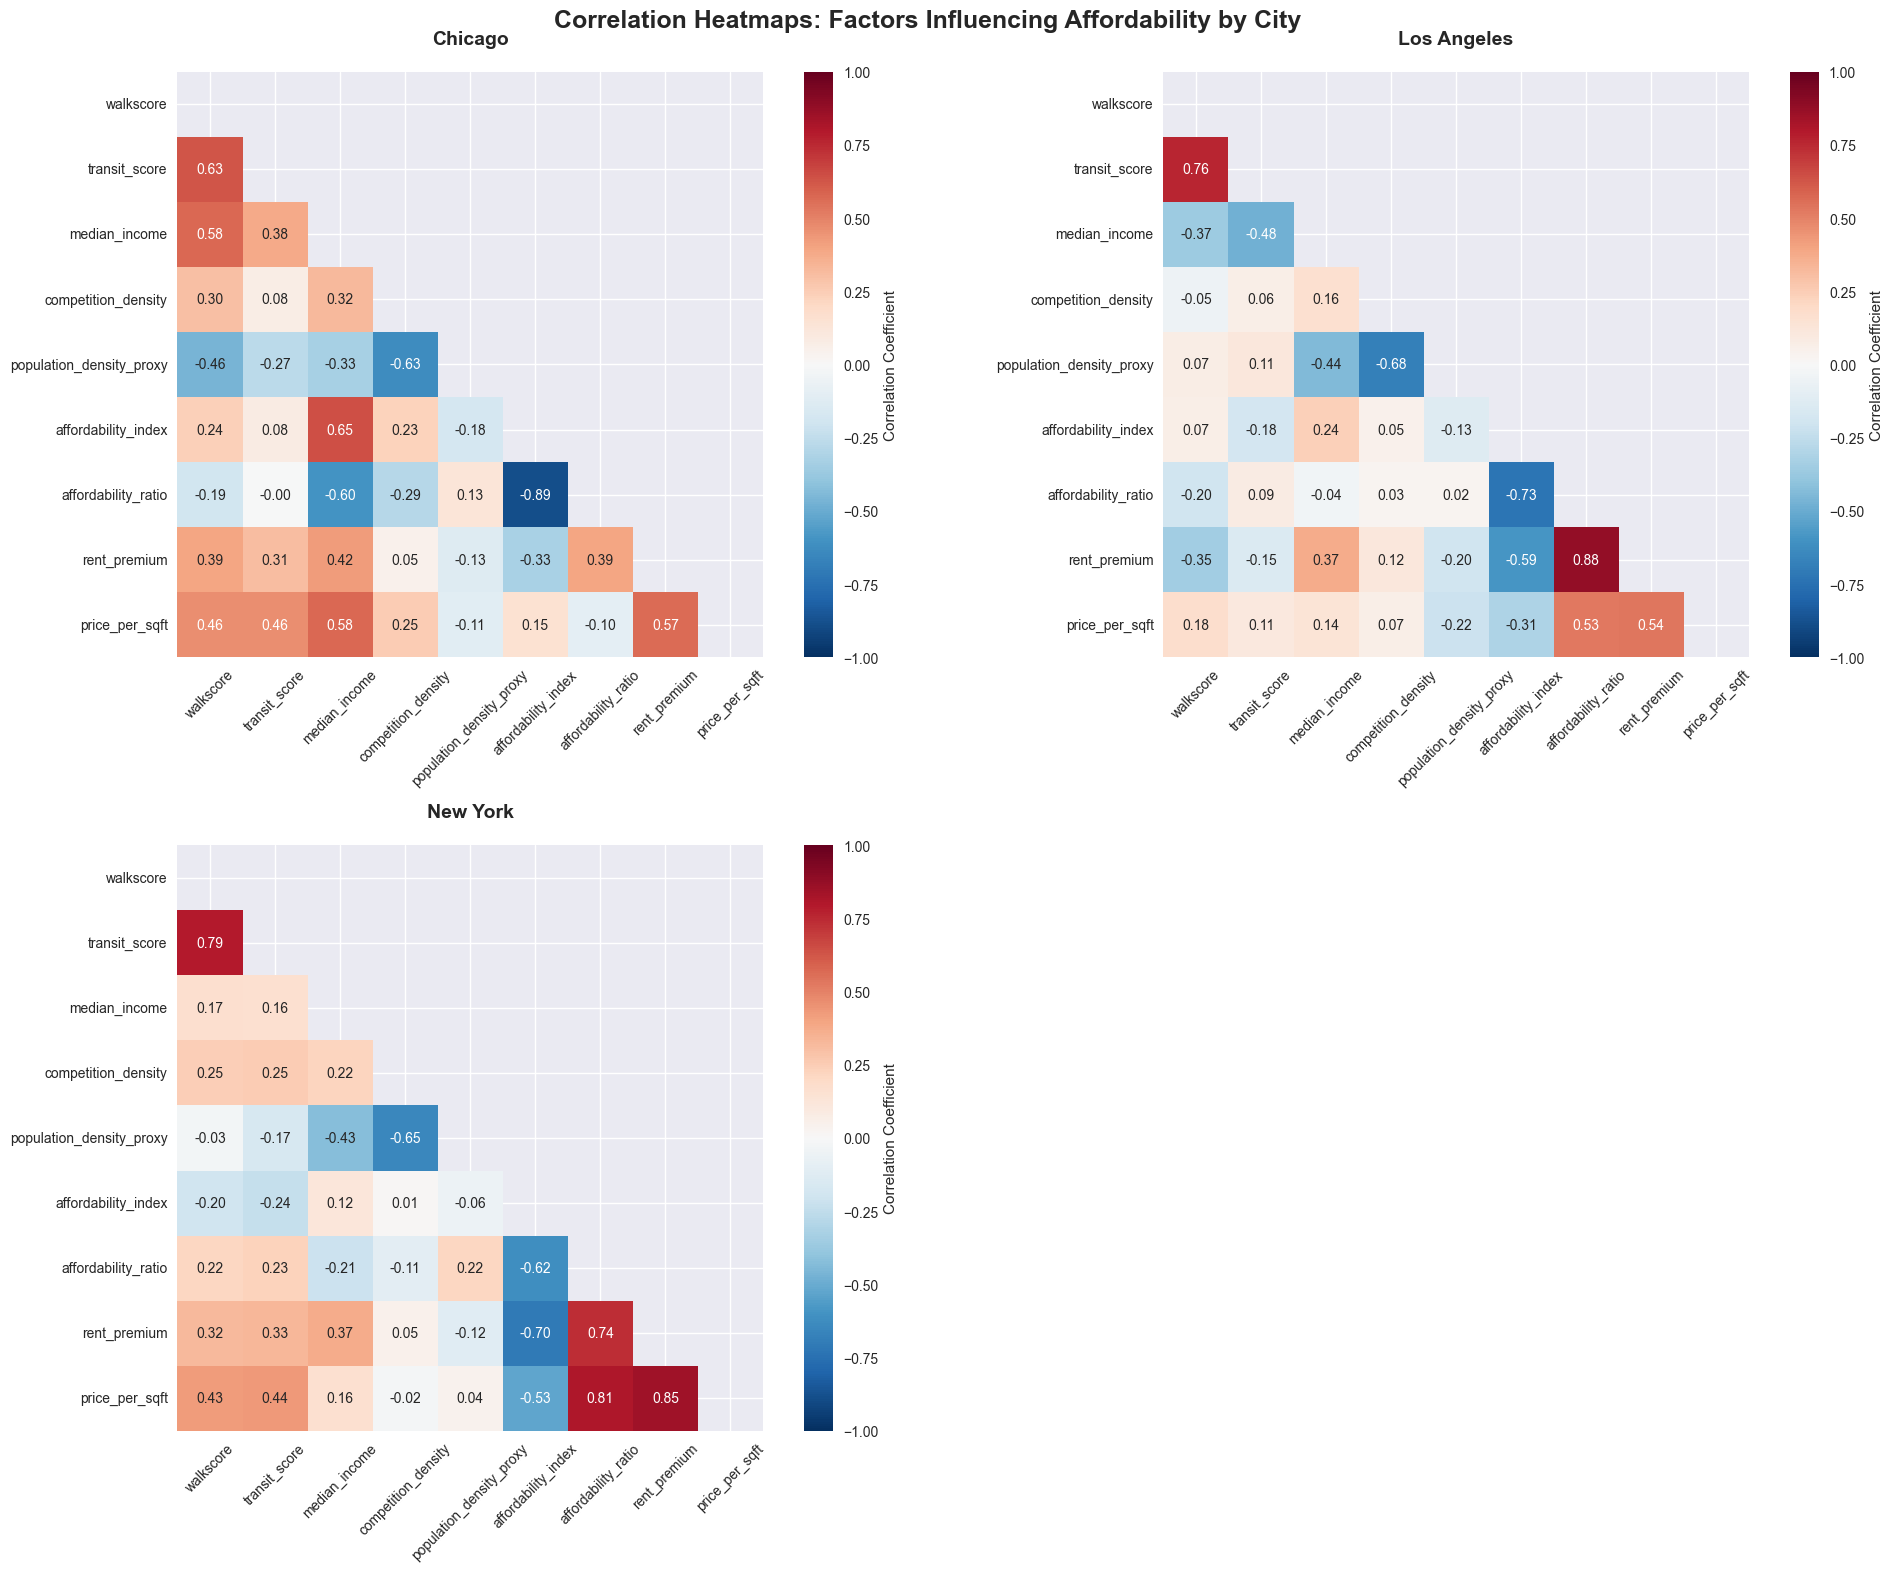

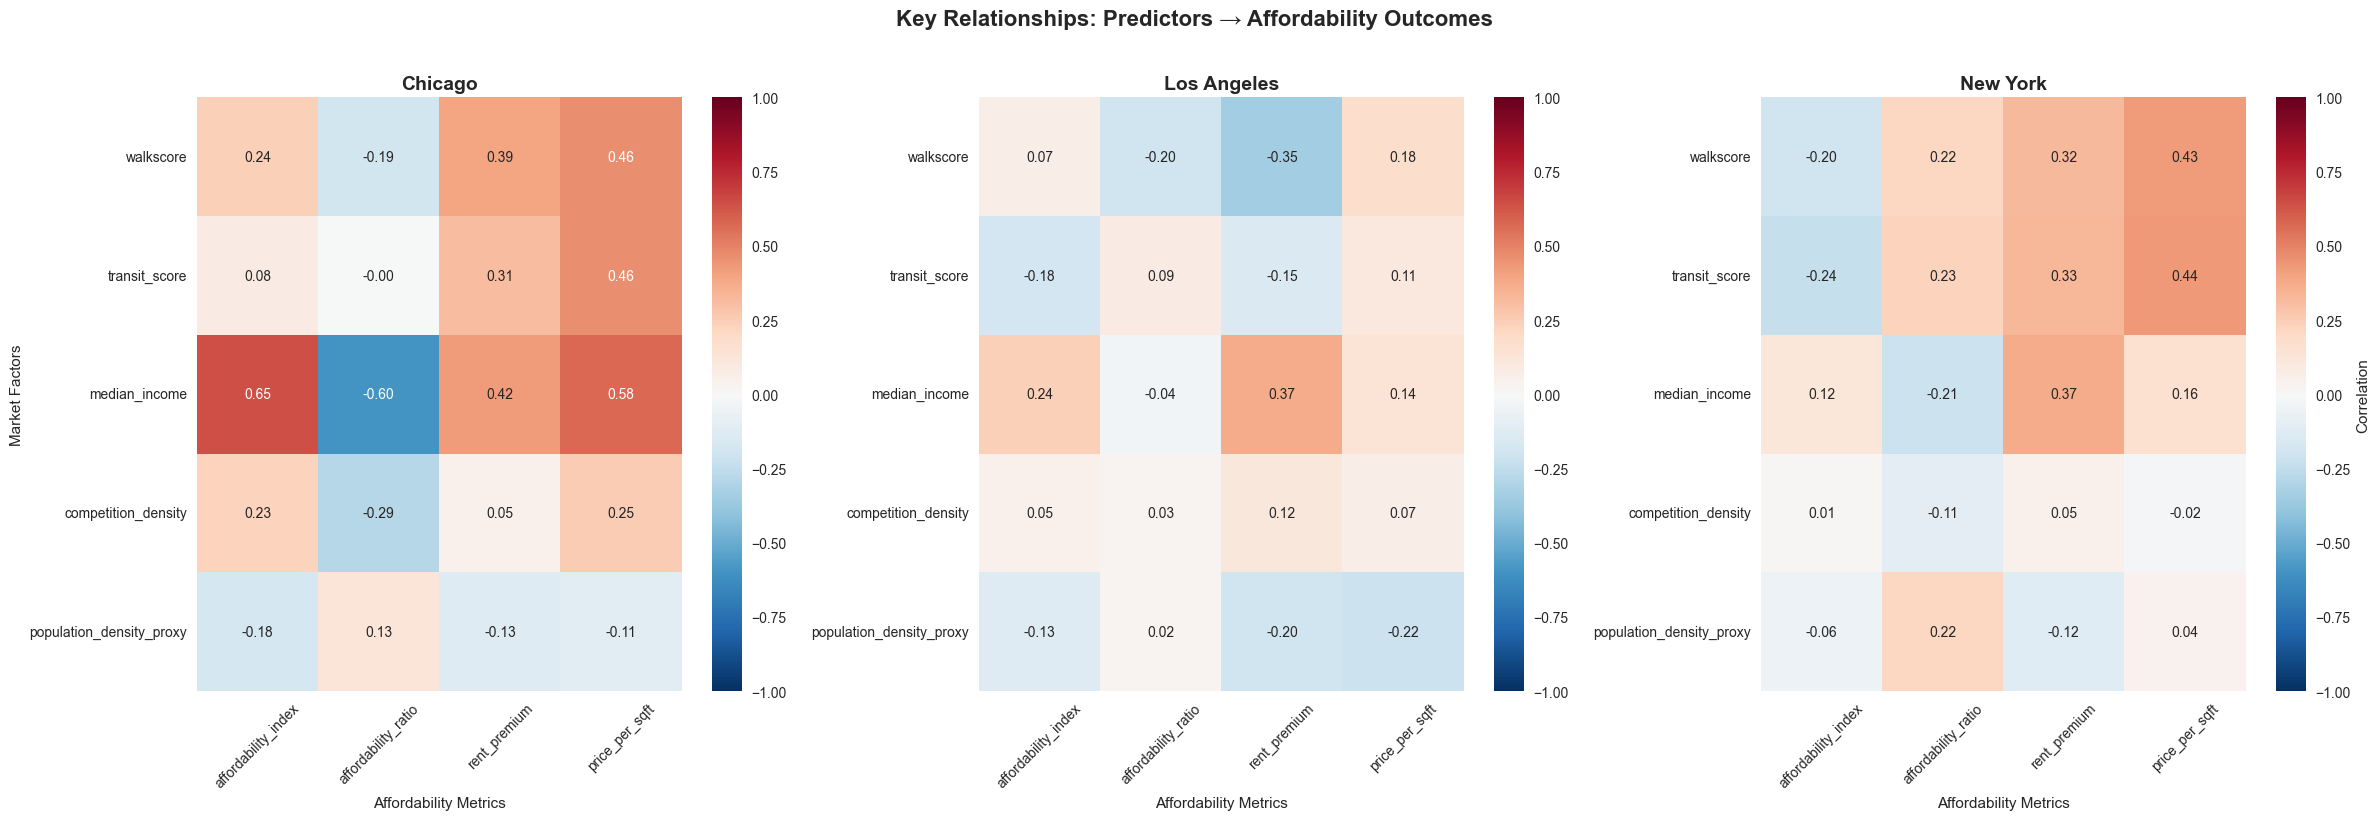


CORRELATION STRENGTH ANALYSIS: TOP INFLUENCES BY CITY

CHICAGO:
--------

Affordability Index:
  • Median Income: +0.648 (STRONG) ↑
  • Walkscore: +0.239 (WEAK) ↑
  • Competition Density: +0.233 (WEAK) ↑

Affordability Ratio:
  • Median Income: -0.597 (STRONG) ↓
  • Competition Density: -0.288 (WEAK) ↓
  • Walkscore: -0.188 (WEAK) ↓

Rent Premium:
  • Median Income: +0.425 (MODERATE) ↑
  • Walkscore: +0.394 (MODERATE) ↑
  • Transit Score: +0.307 (MODERATE) ↑

Price Per Sqft:
  • Median Income: +0.578 (STRONG) ↑
  • Transit Score: +0.464 (MODERATE) ↑
  • Walkscore: +0.463 (MODERATE) ↑

LOS ANGELES:
------------

Affordability Index:
  • Median Income: +0.238 (WEAK) ↑
  • Transit Score: -0.185 (WEAK) ↓
  • Population Density Proxy: -0.130 (WEAK) ↓

Affordability Ratio:
  • Walkscore: -0.201 (WEAK) ↓
  • Transit Score: +0.085 (WEAK) ↑
  • Median Income: -0.036 (WEAK) ↓

Rent Premium:
  • Median Income: +0.373 (MODERATE) ↑
  • Walkscore: -0.350 (MODERATE) ↓
  • Population Density Proxy: -

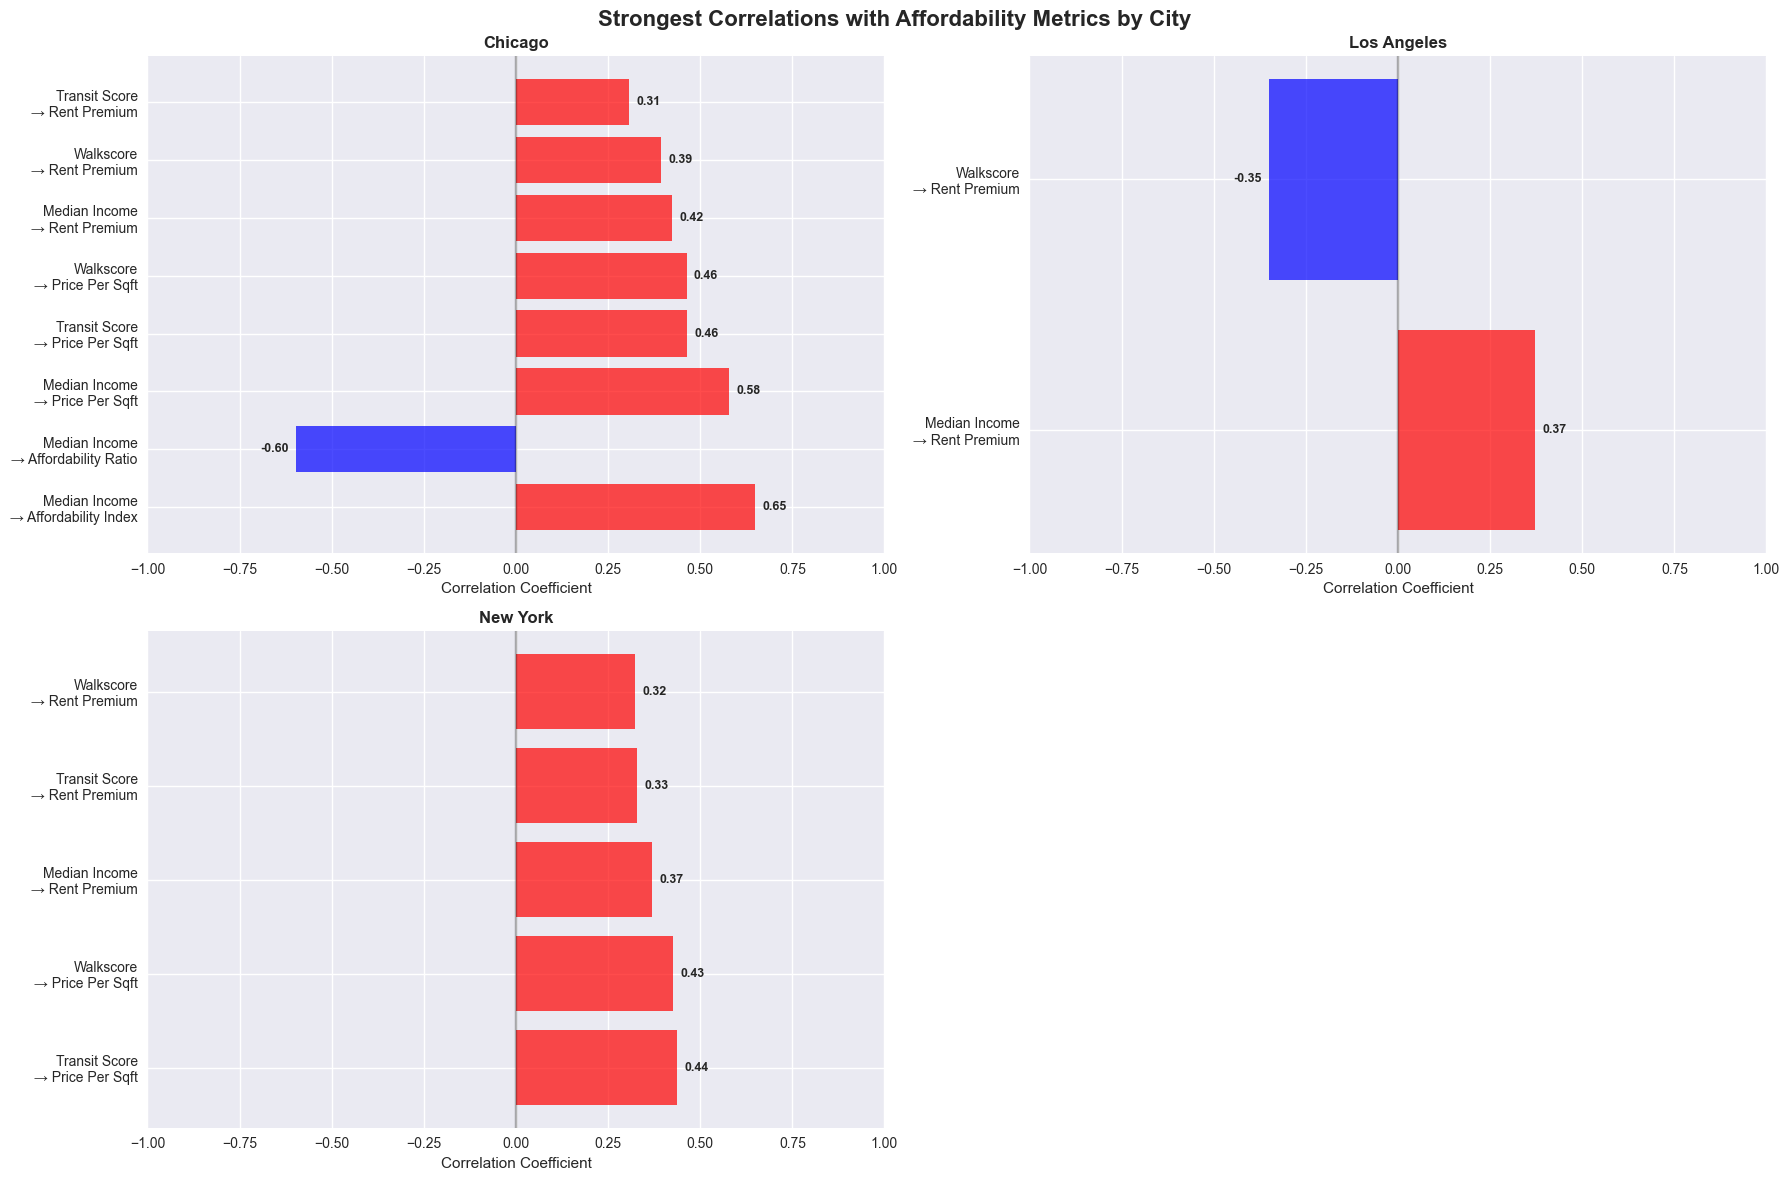


POLICY IMPLICATIONS & QUANTIFIED IMPACTS

CHICAGO - ACTIONABLE INSIGHTS:
-----------------------------
Competition Density and Rent Premium Correlation: +0.051

Median Income → Affordability Ratio: -0.597

Transit Score → Price per Sq Ft: +0.464
FINDING: Better transit → Higher prices (transit premium)
POLICY: Require affordable units in transit-rich developments

🚶 Walk Score → Affordability Index: +0.239

LOS ANGELES - ACTIONABLE INSIGHTS:
---------------------------------
Competition Density and Rent Premium Correlation: +0.116

Median Income → Affordability Ratio: -0.036

Transit Score → Price per Sq Ft: +0.106

🚶 Walk Score → Affordability Index: +0.067

NEW YORK - ACTIONABLE INSIGHTS:
------------------------------
Competition Density and Rent Premium Correlation: +0.052

Median Income → Affordability Ratio: -0.211

Transit Score → Price per Sq Ft: +0.436
FINDING: Better transit → Higher prices (transit premium)
POLICY: Require affordable units in transit-rich developments

🚶 Wa

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

#load the data
df = pd.read_csv('data/clean_data.csv')

#create city groups
df['city_group'] = df['state'].apply(lambda x: 
    'Chicago' if 'IL' in str(x) else
    'Los Angeles' if 'CA' in str(x) or 'LA' in str(x) else
    'New York' if 'NY' in str(x) or 'NYC' in str(x) else
    'Other'
)

#define predictors (thingsand outcomes
predictors = [
    'walkscore', 'transit_score', 'median_income', 
    'competition_density', 'population_density_proxy'
]

outcomes = [
    'affordability_index', 'affordability_ratio', 
    'rent_premium', 'price_per_sqft'
]

all_vars = predictors + outcomes

#filter for main cities and complete data
main_cities = ['Chicago', 'Los Angeles', 'New York']
df_analysis = df[df['city_group'].isin(main_cities)].copy()

#create a clean dataset with all required variables
df_clean = df_analysis[all_vars + ['city_group']].dropna()

# CORRELATION MATRICES BY CITY
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Correlation Heatmaps: Factors Influencing Affordability by City', 
             fontsize=18, fontweight='bold', y=0.98)

correlation_results = {}

for i, city in enumerate(main_cities):
    row, col = i // 2, i % 2
    city_data = df_clean[df_clean['city_group'] == city]
    
    if len(city_data) > 10:  #need sufficient data for meaningful correlations
        #calculate correlation matrix
        corr_matrix = city_data[all_vars].corr()
        correlation_results[city] = corr_matrix
        
        #create heatmap
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  #hide upper triangle
        
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap='RdBu_r',  #red-blue colormap (red = positive, blue = negative)
            center=0,
            square=True,
            mask=mask,
            cbar_kws={'label': 'Correlation Coefficient'},
            fmt='.2f',
            ax=axes[row, col],
            vmin=-1, vmax=1
        )
        
        axes[row, col].set_title(f'{city}\n', 
                               fontsize=14, fontweight='bold', pad=5)
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].tick_params(axis='y', rotation=0)
    else:
        axes[row, col].text(0.5, 0.5, f'{city}\nInsufficient Data\n(n={len(city_data)})', 
                           ha='center', va='center', fontsize=12,
                           transform=axes[row, col].transAxes)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

#remove empty subplot
axes[1, 1].remove()

plt.tight_layout()
plt.show()

# FOCUSED HEATMAP: PREDICTORS vs OUTCOMES ONLY
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Key Relationships: Predictors → Affordability Outcomes', 
             fontsize=16, fontweight='bold', y=1.02)

for i, city in enumerate(main_cities):
    city_data = df_clean[df_clean['city_group'] == city]
    
    if len(city_data) > 10:
        #predictor-outcome correlations only
        corr_matrix = city_data[all_vars].corr()
        focused_corr = corr_matrix.loc[predictors, outcomes]
        
        #create heatmap
        sns.heatmap(
            focused_corr,
            annot=True,
            cmap='RdBu_r',
            center=0,
            cbar_kws={'label': 'Correlation'} if i == 2 else None,
            fmt='.2f',
            ax=axes[i],
            vmin=-1, vmax=1
        )
        
        axes[i].set_title(f'{city}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Affordability Metrics')
        axes[i].set_ylabel('Market Factors' if i == 0 else '')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# CORRELATION STRENGTH ANALYSIS
print("\n" + "="*80)
print("CORRELATION STRENGTH ANALYSIS: TOP INFLUENCES BY CITY")
print("="*80)

#find strongest correlations for each outcome by city
strong_correlations = {}

for city in main_cities:
    if city in correlation_results:
        corr_matrix = correlation_results[city]
        strong_correlations[city] = {}
        
        print(f"\n{city.upper()}:")
        print("-" * (len(city) + 1))
        
        for outcome in outcomes:
            #get correlations with predictors for this outcome
            outcome_corrs = corr_matrix.loc[predictors, outcome].abs().sort_values(ascending=False)
            
            print(f"\n{outcome.replace('_', ' ').title()}:")
            for predictor in outcome_corrs.index[:3]:  # Top 3 predictors
                corr_val = corr_matrix.loc[predictor, outcome]
                strength = "STRONG" if abs(corr_val) > 0.5 else "MODERATE" if abs(corr_val) > 0.3 else "WEAK"
                direction = "↑" if corr_val > 0 else "↓"
                
                print(f"  • {predictor.replace('_', ' ').title()}: {corr_val:+.3f} ({strength}) {direction}")
                
                #store for later analysis
                if outcome not in strong_correlations[city]:
                    strong_correlations[city][outcome] = []
                strong_correlations[city][outcome].append((predictor, corr_val))

# BAR CHART: TOP INFLUENCERS BY CITY
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Strongest Correlations with Affordability Metrics by City', 
             fontsize=16, fontweight='bold', y=0.98)

for i, city in enumerate(main_cities):
    row, col = i // 2, i % 2
    
    if city in correlation_results:
        #collect all strong correlations (>0.3) for this city
        strong_pairs = []
        
        for outcome in outcomes:
            for predictor in predictors:
                corr_val = correlation_results[city].loc[predictor, outcome]
                if abs(corr_val) > 0.3:
                    pair_name = f"{predictor.replace('_', ' ').title()}\n→ {outcome.replace('_', ' ').title()}"
                    strong_pairs.append((pair_name, corr_val))
        
        if strong_pairs:
            #sort by absolute correlation strength
            strong_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
            
            #take top 8
            top_pairs = strong_pairs[:8]
            
            names = [pair[0] for pair in top_pairs]
            values = [pair[1] for pair in top_pairs]
            colors = ['red' if v > 0 else 'blue' for v in values]
            
            bars = axes[row, col].barh(names, values, color=colors, alpha=0.7)
            axes[row, col].set_title(f'{city}', fontweight='bold')
            axes[row, col].set_xlabel('Correlation Coefficient')
            axes[row, col].axvline(x=0, color='black', linestyle='-', alpha=0.3)
            axes[row, col].set_xlim(-1, 1)
            
            #add value labels
            for j, (bar, val) in enumerate(zip(bars, values)):
                axes[row, col].text(val + (0.02 if val > 0 else -0.02), j, 
                                  f'{val:.2f}', ha='left' if val > 0 else 'right', 
                                  va='center', fontweight='bold', fontsize=9)
        else:
            axes[row, col].text(0.5, 0.5, f'{city}\nNo Strong Correlations\n(|r| > 0.3)', 
                              ha='center', va='center', transform=axes[row, col].transAxes)

#remove empty subplot
axes[1, 1].remove()

plt.tight_layout()
plt.show()

# POLICY IMPLICATIONS AND QUANTIFIED IMPACTS
print("\n" + "="*80)
print("POLICY IMPLICATIONS & QUANTIFIED IMPACTS")
print("="*80)

#analyze specific relationships mentioned in the goal
for city in main_cities:
    if city in correlation_results:
        corr_matrix = correlation_results[city]
        city_data = df_clean[df_clean['city_group'] == city]
        
        print(f"\n{city.upper()} - ACTIONABLE INSIGHTS:")
        print("-" * (len(city) + 22))
        
        #competition density impact on rent premium
        if 'competition_density' in corr_matrix.index and 'rent_premium' in corr_matrix.columns:
            comp_rent_corr = corr_matrix.loc['competition_density', 'rent_premium']
            
            print(f"Competition Density and Rent Premium Correlation: {comp_rent_corr:+.3f}")
            
            if abs(comp_rent_corr) > 0.3:
                #calculate potential impact of policy intervention
                #done by AI
                comp_std = city_data['competition_density'].std()
                rent_std = city_data['rent_premium'].std()
                
                #estimate impact of 1 standard deviation change in competition
                impact_estimate = (comp_rent_corr * rent_std / comp_std) * comp_std
                
                if comp_rent_corr < -0.3:
                    print(f"FINDING: More competition → Lower rent premiums")
                    print(f"ESTIMATE: Increasing competition by 1 std dev could reduce rent premium by ${abs(impact_estimate):.0f}")
                    print(f"POLICY: Push for more development permits & reduce zoning barriers")
                elif comp_rent_corr > 0.3:
                    print(f"FINDING: More competition → Higher rent premiums (market saturation)")
                    print(f"ESTIMATE: Need to examine supply-demand imbalances")
                    print(f"POLICY: Focus on transit accessibility rather than just supply")
        
        #income effects
        income_afford_corr = corr_matrix.loc['median_income', 'affordability_ratio']
        print(f"\nMedian Income → Affordability Ratio: {income_afford_corr:+.3f}")
        
        if income_afford_corr > 0.3:
            print(f"FINDING: Higher income areas have better affordability ratios")
            print(f"POLICY: Target affordable housing in high-income, high-opportunity areas")
        
        #transit effects
        transit_price_corr = corr_matrix.loc['transit_score', 'price_per_sqft']
        print(f"\nTransit Score → Price per Sq Ft: {transit_price_corr:+.3f}")
        
        if transit_price_corr > 0.3:
            print(f"FINDING: Better transit → Higher prices (transit premium)")
            print(f"POLICY: Require affordable units in transit-rich developments")
        
        #walkability effects  
        walk_afford_corr = corr_matrix.loc['walkscore', 'affordability_index']
        print(f"\n🚶 Walk Score → Affordability Index: {walk_afford_corr:+.3f}")

# SUMMARY TABLE OF KEY CORRELATIONS
print("\n" + "="*80)
print("SUMMARY TABLE: KEY CORRELATIONS BY CITY")
print("="*80)

summary_df = pd.DataFrame(index=main_cities, 
                         columns=['Competition→Rent Premium', 'Income→Affordability', 
                                'Transit→Price/SqFt', 'Walk→Affordability'])

for city in main_cities:
    if city in correlation_results:
        corr_matrix = correlation_results[city]
        
        summary_df.loc[city, 'Competition→Rent Premium'] = f"{corr_matrix.loc['competition_density', 'rent_premium']:.3f}"
        summary_df.loc[city, 'Income→Affordability'] = f"{corr_matrix.loc['median_income', 'affordability_ratio']:.3f}"
        summary_df.loc[city, 'Transit→Price/SqFt'] = f"{corr_matrix.loc['transit_score', 'price_per_sqft']:.3f}"
        summary_df.loc[city, 'Walk→Affordability'] = f"{corr_matrix.loc['walkscore', 'affordability_index']:.3f}"

print(summary_df)

# INVESTMENT MODELING INSIGHTS
print(f"\n{'FOR-PROFIT STAKEHOLDERS - INVESTMENT MODELING:'}")
print("• Use correlation strengths to weight factors in pricing models")
print("• Target markets where competition_density negatively correlates with rent_premium")
print("• Avoid oversaturated markets (positive competition-premium correlations)")

print(f"\n{'SOCIAL ADVOCATES - CAMPAIGN EVIDENCE:'}")
print("• Cite specific correlation coefficients in policy briefs")
print("• Use city-specific data to counter 'one-size-fits-all' arguments")
print("• Highlight where more supply (competition) would reduce premiums")

print(f"\nAnalysis complete! Correlation analysis covers {len(df_clean)} properties across {len(main_cities)} cities.")
print(f"Strong correlations (|r| > 0.5) highlighted for policy action.")

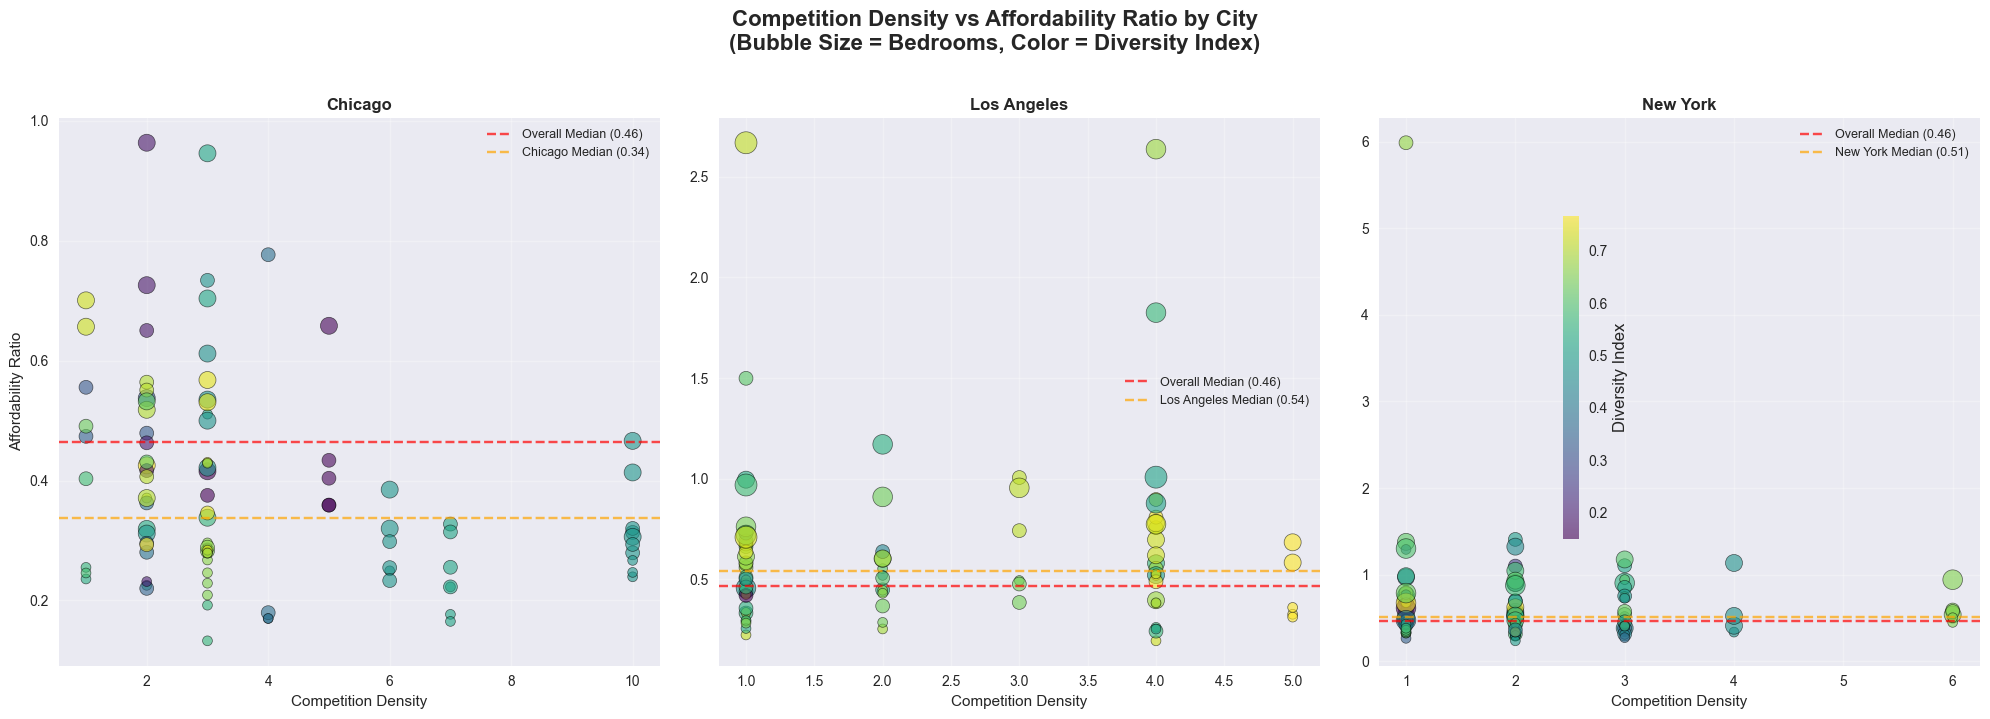

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

#load the data
df = pd.read_csv('data/clean_data.csv')

#create city groups
df['city_group'] = df['state'].apply(lambda x: 
    'Chicago' if 'IL' in str(x) else
    'Los Angeles' if 'CA' in str(x) or 'LA' in str(x) else
    'New York' if 'NY' in str(x) or 'NYC' in str(x) else
    'Other'
)

#filter for main cities and required variables
main_cities = ['Chicago', 'Los Angeles', 'New York']
required_vars = ['competition_density', 'affordability_ratio', 'bedrooms', 'diversity_index', 'city_group']

df_bubble = df[df['city_group'].isin(main_cities)].copy()
df_clean = df_bubble[required_vars].dropna()

#create bedroom categories for better analysis
df_clean['bedroom_category'] = df_clean['bedrooms'].apply(lambda x: 
    'Studio/1BR' if x <= 1 else
    '2BR' if x == 2 else
    '3+BR' if x >= 3 else 'Unknown'
)

# STATIC BUBBLE CHART WITH MATPLOTLIB/SEABORN
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Competition Density vs Affordability Ratio by City\n(Bubble Size = Bedrooms, Color = Diversity Index)', 
             fontsize=16, fontweight='bold', y=1.02)

#color map for diversity index
diversity_cmap = plt.cm.viridis

# calculate overall median affordability ratio
median_afford = df_clean['affordability_ratio'].median()

for i, city in enumerate(main_cities):
    city_data = df_clean[df_clean['city_group'] == city]
    
    if len(city_data) > 0:
        #create scatter plot
        scatter = axes[i].scatter(
            city_data['competition_density'],
            city_data['affordability_ratio'],
            s=city_data['bedrooms'] * 50,  #size by bedrooms
            c=city_data['diversity_index'],  #color by diversity
            cmap=diversity_cmap,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )
        
        axes[i].set_title(f'{city}', fontweight='bold')
        axes[i].set_xlabel('Competition Density')
        axes[i].set_ylabel('Affordability Ratio' if i == 0 else '')
        axes[i].grid(True, alpha=0.3)
        
        #add median lines
        axes[i].axhline(y=median_afford, color='red', linestyle='--', alpha=0.7, 
                       label=f'Overall Median ({median_afford:.2f})')
        
        city_median = city_data['affordability_ratio'].median()
        axes[i].axhline(y=city_median, color='orange', linestyle='--', alpha=0.7,
                       label=f'{city} Median ({city_median:.2f})')
        
        axes[i].legend(fontsize=9)

#add colorbar
cbar = plt.colorbar(scatter, ax=axes, shrink=0.6, pad=0.01)
cbar.set_label('Diversity Index', fontsize=12)

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

df = pd.read_csv("data/clean_data.csv")

#filter to only New York State
ny_state = df[df["state"] == "NY"]
#show unique city names within NY state
unique_ny_cities = ny_state["city"].unique()
print(f"Unique cities/neighborhoods in NY state ({len(unique_ny_cities)} total):")
print(unique_ny_cities)

#california
ca_state = df[df["state"] == "CA"]
unique_ca_cities = ca_state["city"].unique()
print(f"\nUnique cities/neighborhoods in CA state ({len(unique_ca_cities)} total):")
print(unique_ca_cities)

#illinois
il_state = df[df["state"] == "IL"]
unique_il_cities = il_state["city"].unique()
print(f"\nUnique cities/neighborhoods in IL state ({len(unique_il_cities)} total):")
print(unique_il_cities)


Unique cities/neighborhoods in NY state (15 total):
['Brooklyn' 'Staten Island' 'New York' 'Bronx' 'Arverne' 'Jamaica'
 'Astoria' 'Far Rockaway' 'Fresh Meadows' 'Corona' 'Hollis'
 'Long Island City' 'Kew Gardens' 'Jackson Heights' 'East Elmhurst']

Unique cities/neighborhoods in CA state (15 total):
['Los Angeles' 'Sherman Oaks' 'Van Nuys' 'Encino' 'Studio City'
 'West Hollywood' 'North Hollywood' 'Winnetka' 'Reseda' 'North Hills'
 'Wilmington' 'Tarzana' 'Tujunga' 'Valley Village' 'Chatsworth']

Unique cities/neighborhoods in IL state (1 total):
['Chicago']
